## Prétraitement des phrases

### Découpage en "sous-mot"

    [b'[START]' b'and' b'when' b'you' b'improve' b'search' b'##ability' b',' b'you' b'actually' b'take' b'away' b'the' b'one' b'advantage' b'of' b'print' b',' b'which' b'is' b's' b'##ere' b'##nd' b'##ip' b'##ity' b'.' b'[END]']
    [b'[START]' b'but' b'what' b'if' b'it' b'were' b'active' b'?' b'[END]']
    [b'[START]' b'but' b'they' b'did' b'n' b"'" b't' b'test' b'for' b'curiosity' b'.' b'[END]']

### Tokenisation

    [2, 44, 115, 6402, 148, 40, 887, 14, 3936, 40, 463, 2715, 94, 2047, 14, 84, 44, 40, 117, 1328, 2721, 818, 539, 16, 3]
    [2, 99, 44, 89, 199, 2836, 1336, 3996, 32, 3]
    [2, 99, 131, 88, 383, 40, 2673, 83, 110, 1972, 16, 3]

### Embeding

A chaque token est associé un vecteur de grande dimension. Au cours de l'entrainement,  ces vecteurs vont se positionner pour que les relations vectorielles traduisent des relations sémentiques.

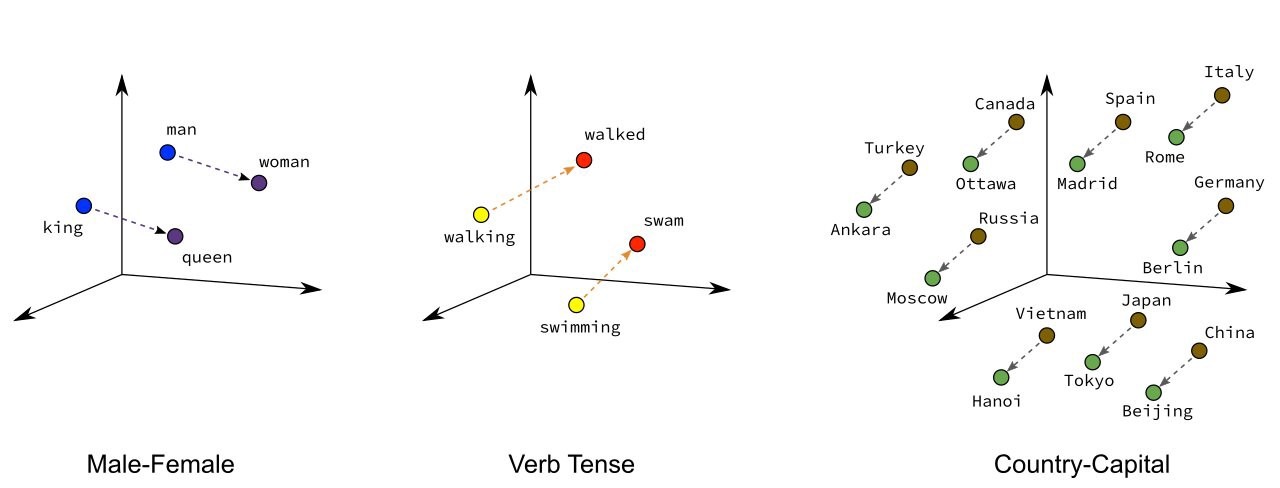

### Encodage positionnel

Un transformer prend en entrée une séquence sans se soucier de l'ordre des éléments. Or dans une phrase, l'ordre des éléments apporte une information importante



Pour chaque token, on va associer un "encodage positionnel" (une feature de plus), sous la forme d'un grand vecteur quand deux tokenq sont proches dans une phrase, ils ont un encodage positionnel proche.

La formule pour calculer cet encodage positionnel est la suivante: En notant $pos$ l'indice de la position du token, le vecteur est une sorte de série de fourier:


$${PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Il existe d'autre encodage positionnel, où les "fréquences" qui apparaissent sont des trainable-variables.

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
pos_encoding_example = positional_encoding(MAX_SEQ_LEN, 512)
print(pos_encoding_example.shape)

In [ ]:
dims=[400,399,300,299,200,199,100,99]
fig,axs=plt.subplots(len(dims),1,sharex="all")

for i,dim in enumerate(dims):
    axs[i].plot(pos_encoding_example[0,:,dim])

In [ ]:
pos_encoding_example_T = tf.transpose(pos_encoding_example[0,:,::2])

plt.pcolormesh(pos_encoding_example_T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar();

In [ ]:
pos_encoding_example_T = tf.transpose(pos_encoding_example[0,:,:])

plt.pcolormesh(pos_encoding_example_T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar();

Pourquoi mettre les sinus et les cosinus ?

### Le pipeline complet

On choisit une dimension de travail `d= 12288`  et une longueur maximale de phrase `L=2048`

* Chaque suite de token est complée par des  0 pour arriver à la longueur `L` Ainsi chaque batch de phrase est rangée dans une matrice `(batch_size,L)`
* Par embeding: à chaque token est associé un vecteur de dimension d. On obtient ainsi un tenseur (batch_size,L,d)`
* Par l'encodage positionnel: à chaque position est associée un vecteur de dimension `d`. On obtient ainsi un tenseur (batch_size,L,d)`
*  On fait la somme de ces deux tenseurs.





Cette addition peut paraitre étonnante: on aurait mieux vu une concaténation puisqu'il s'agit de features distinctes.

Mais il faut comprendre qu'en grande dimension, les vecteurs sont très facilement orthogonaux. Dans le cas de vecteur orthogonaux, la concaténation et la somme sont assez similaire comme le montre l'exemple ci-dessous:


    (1,2) concat (3,4) = (1,2,3,4)

    (1,2,0,0) orthogonal à (0,0,3,4) et leur somme donne le vecteur du dessus.







## Chat GPT de la première à la dernière couche

Ci-dessous un schéma complet du modèle GPT.  J'ai fait confiance au tuto [ici](https://dugas.ch/artificial_curiosity/GPT_architecture.html) qui m'a charmé par ses dessins très clairs.

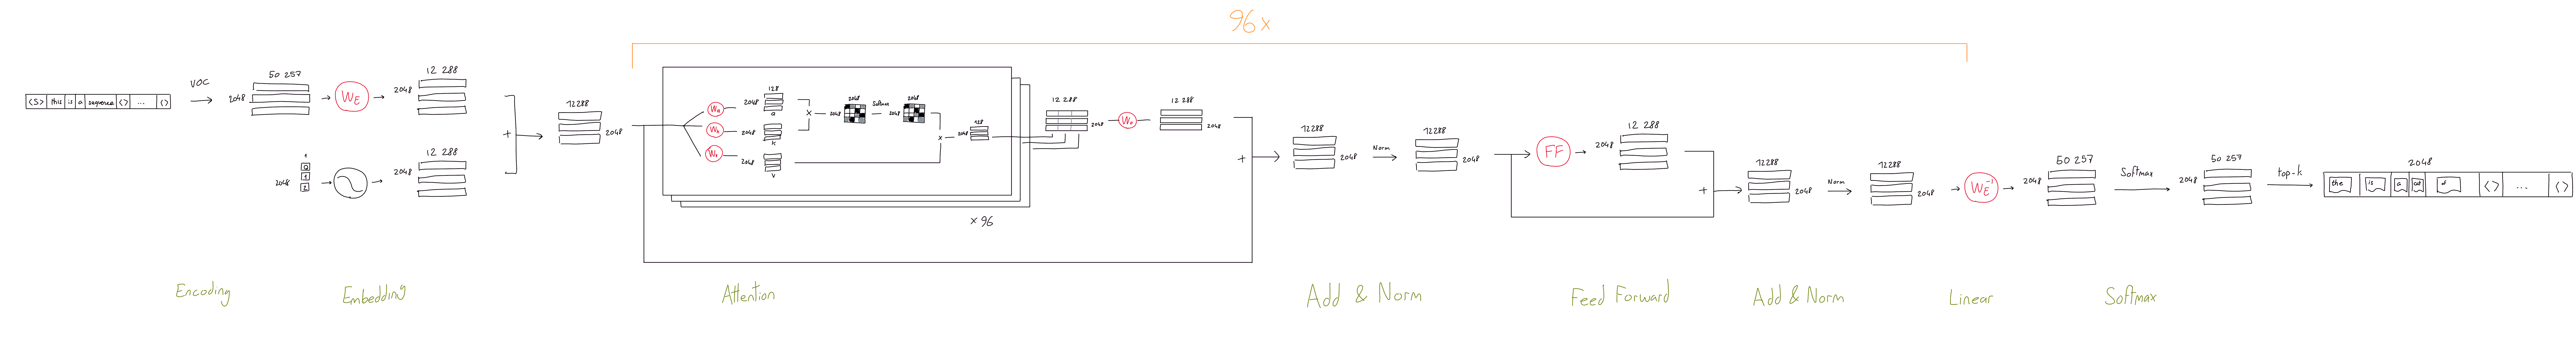

### Embedding

Les phrases ont une longueur de 2048 mots.

Le vocabualire est de 50257 mots.

Les mots sont encodé en des vecteurs de taille 12288.

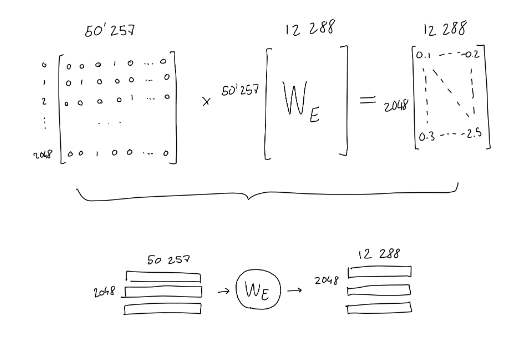

Le dessin ci-dessus sugère pour pour encore une phrase on passe par un one-hot encoding. C'est juste une illustration. Informatiquement on n'en pas pas besoin du tout.

### Encodage positionnel

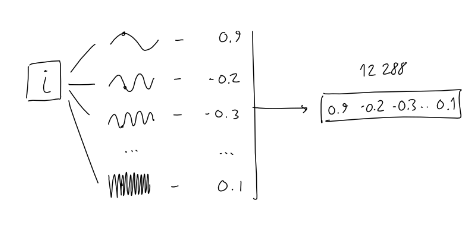

Chacun indice de position est passé dans 12288 sinusoides.

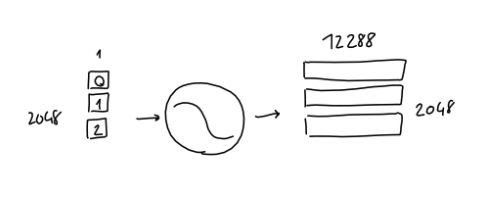

Ainsi la suite de toutes les position: le vecteur 0,1,...2047 est encodé en une matrice 12288*2048

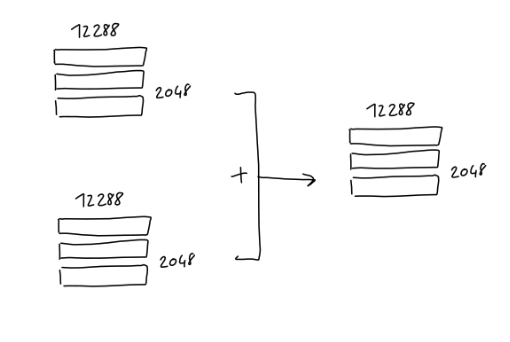

Cette matrice est ensuite additionnée avec la matrice représentant une phrase

### Attention multi-tête

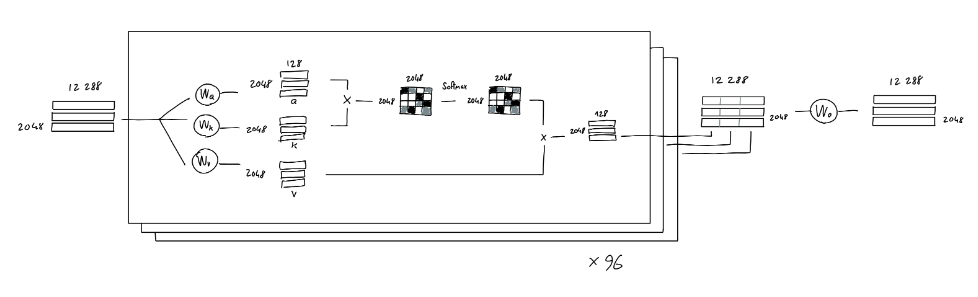

Le nombre de tête est de 96.

Pour chacune des têtes, la head_depth est de 128.

Contrairement à ce que suggère le dessin, les 3 matrices Q,K,V sont obtenues à partir de l'entrée précédente X (de taille 2048*12 288) par une seule multiplication matricielle par une matrice W entrainable. Le résultat de cette multiplication est ensuite découpé en 96 (suivant l'axe de la `depth` bien sur).



In [ ]:
# transformation puis découpage
12288**2 *3

In [ ]:
# découpage puis transformation
128**2*3*96

Les 96 résutats des têtes sont concaténées entre elle en une matrice de taille 2028*12288, puis mélangées par une multiplication matricielle qui garde la même shape.


***A vous:***
* Combien de paramètres en tout quand on compte toutes les têtes ?
* Combien d'opération en tout ? Quelle est la taille des `attention_weights` ?

Pour limiter les calculs, GPT utilise une réduction des calculs appelés `sparse-attention`.

### Juste l'attention




Le dessin que fait l'auteur de l'attention est très sympa aussi. Mais attention, là les tailles ne sont pas les vraies longeur séquence seulement 3, et depth seulement 512.

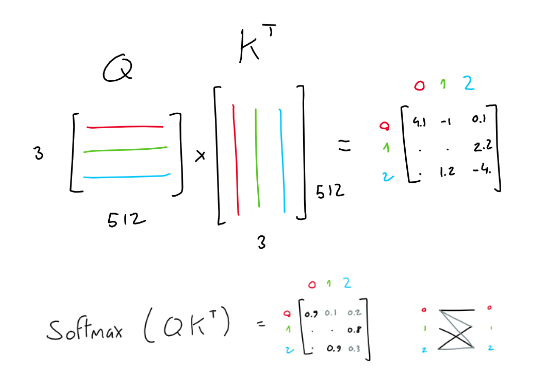

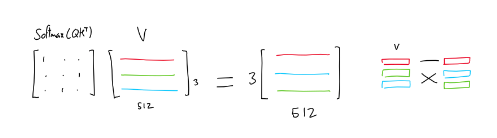

### Feed wordward



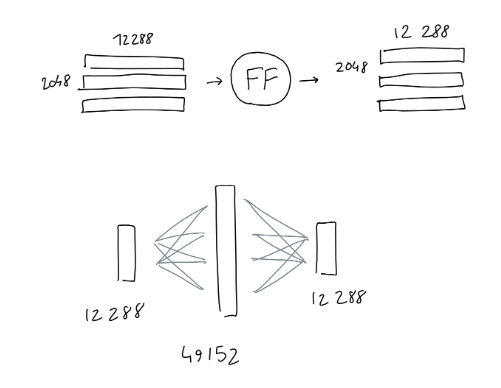


C'est un réseau à une couche caché, dont la taille est de 49152. Les fonctions d'activation `relu`.

On ajoute bien des biais même si ce n'est pas dessiné.

### Add et norm

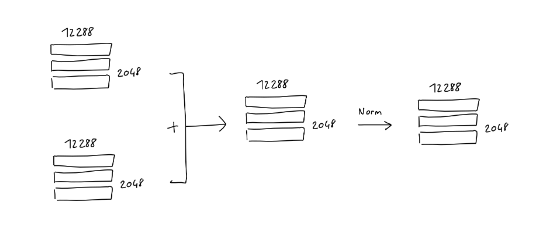

### Empilement des blocks

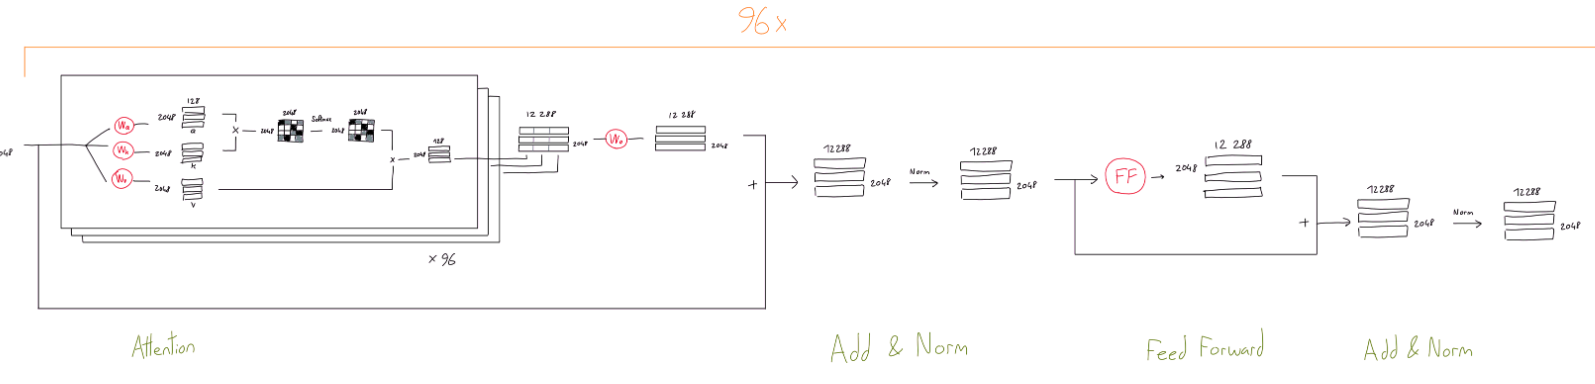

Le block est répéter 96 fois.

### Décodage final

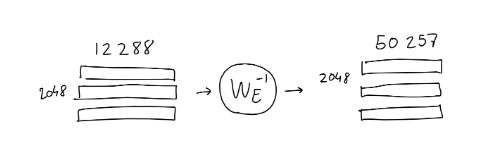

La sortie du dernier block  est transformé une suite de logits par une multiplication matricielle.

### Mega défi

Vous avez tous les élément pour calculer combien il y a au total de paramètres dans le modèle GPT3. Ils sont marqué en rouge dans le schéma global.

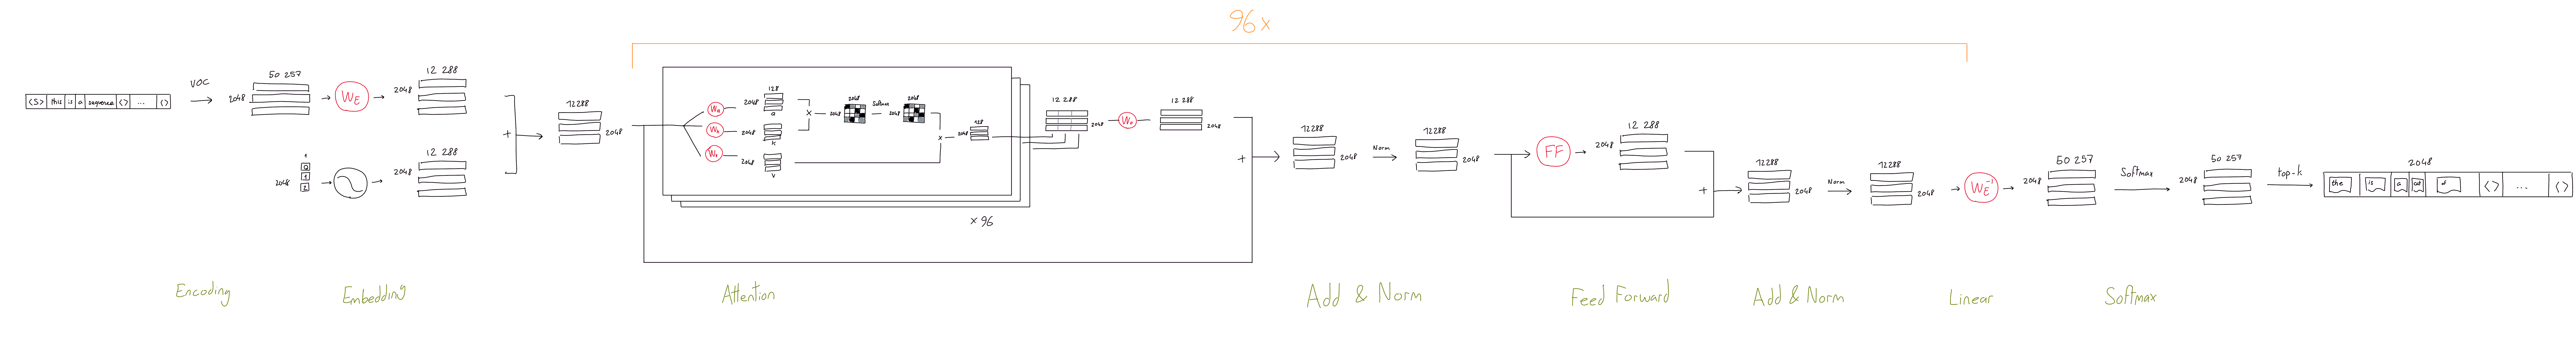